# Import data and packages

In [8]:
# Import packages
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

## Pre subprime

In [9]:
# Load .csv
df_pre = pd.read_csv("extracted_risks_2006.csv")

# Fill missing values
df_pre["risk_type"] = df_pre["risk_type"].fillna("unspecified")

# Drop expectations, as it is not useful
df_pre = df_pre.drop(columns=["expectations"])

df_pre.head()

,transcript_id,company,speaker_role,risk_type
0,0.0,"Agilent Technologies, Inc.",Vice President and Treasurer,forward-looking statements
1,0.0,"Agilent Technologies, Inc.","President, CEO",forward-looking statements
2,0.0,"Agilent Technologies, Inc.","Executive Vice President, Finance and Administ...",forward-looking statements
3,1.0,Agilent Technologies,CEO,market demand
4,1.0,Agilent Technologies,CEO,competition


## Post subprime

In [10]:
# Load .csv
df_post = pd.read_csv("extracted_risks_2008.csv")

# Fill missing values
df_post["risk_type"] = df_post["risk_type"].fillna("unspecified")

# Drop expectations, as it is not useful
df_post = df_post.drop(columns=["expectations"])

df_post.head()

,transcript_id,company,speaker_role,risk_type
0,0.0,Amphenol Corporation,CFO,economic downturn
1,0.0,Amphenol Corporation,CEO,economic downturn
2,0.0,Amphenol Corporation,President & COO,economic downturn
3,0.0,Amphenol Corporation,CFO,economic downturn
4,0.0,Amphenol Corporation,CFO,slowdown in spending


# Graph

## Pre suborime crisis

In [11]:
# Initialize an undirected bipartite graph
G_pre = nx.Graph()

# Add nodes and edges
for _, row in df_pre.iterrows():
    company = row["company"]
    risk = row["risk_type"]

    # Add nodes with type attributes
    G_pre.add_node(company, type="company")
    G_pre.add_node(risk, type="risk")

    # Add edge with sentiment info
    if G_pre.has_edge(company, risk):
        # Increment weight if already exists
        G_pre[company][risk]["weight"] += 1
    else:
        G_pre.add_edge(company, risk, weight=1)

print(f"✅ Graph created with {len(G_pre.nodes())} nodes and {len(G_pre.edges())} edges")

✅ Graph created with 469 nodes and 652 edges


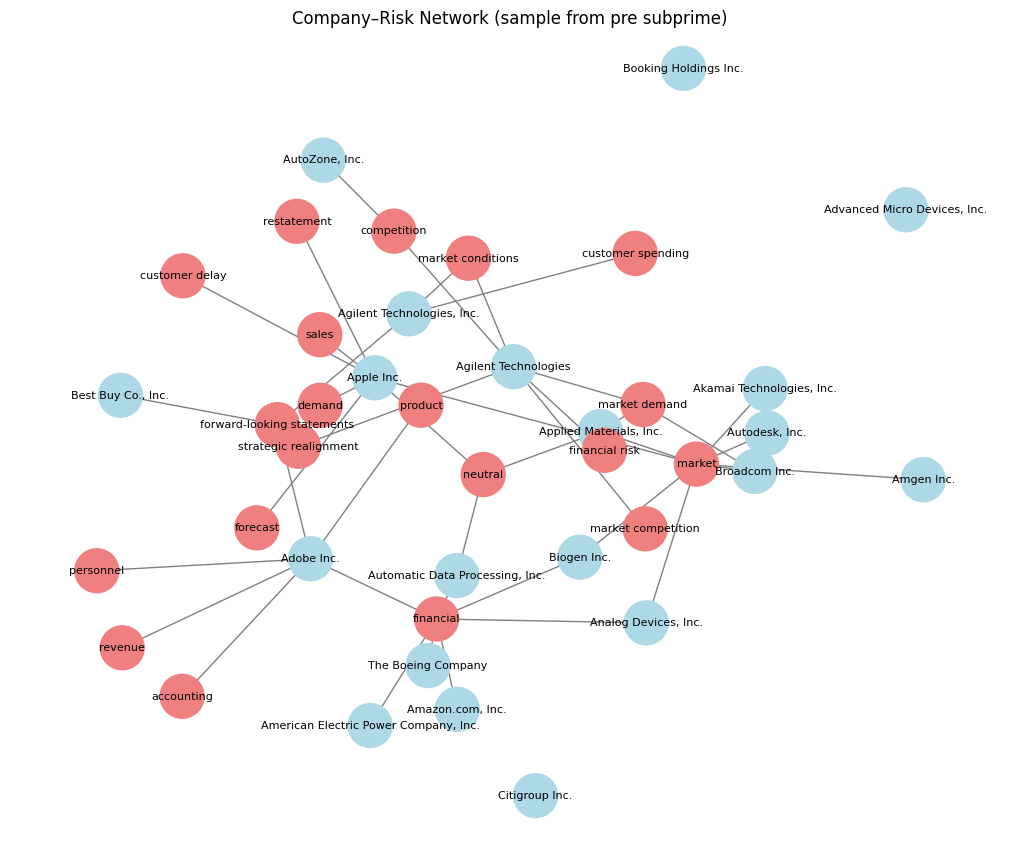

In [25]:
# Focus on top 20 nodes
sub_nodes = list(df_pre["company"].unique())[:20] + list(df_pre["risk_type"].unique())[:20]
H = G_pre.subgraph(sub_nodes)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(H, k=0.5)
node_colors = ["lightblue" if G_pre.nodes[n]["type"] == "company" else "lightcoral" for n in H.nodes()]

nx.draw(
    H,
    pos,
    with_labels=True,
    node_color=node_colors,
    edge_color="gray",
    font_size=8,
    node_size=1000,
)
plt.title("Company–Risk Network (sample from pre subprime)")
plt.show()


## Post subprime crisis

In [13]:
# Initialize an undirected bipartite graph
G_post = nx.Graph()

# Add nodes and edges
for _, row in df_post.iterrows():
    company = row["company"]
    risk = row["risk_type"]

    # Add nodes with type attributes
    G_post.add_node(company, type="company")
    G_post.add_node(risk, type="risk")

    # Add edge with sentiment info
    if G_post.has_edge(company, risk):
        # Increment weight if already exists
        G_post[company][risk]["weight"] += 1
    else:
        G_post.add_edge(company, risk, weight=1)

print(f"✅ Graph created with {len(G_post.nodes())} nodes and {len(G_post.edges())} edges")

✅ Graph created with 779 nodes and 1042 edges


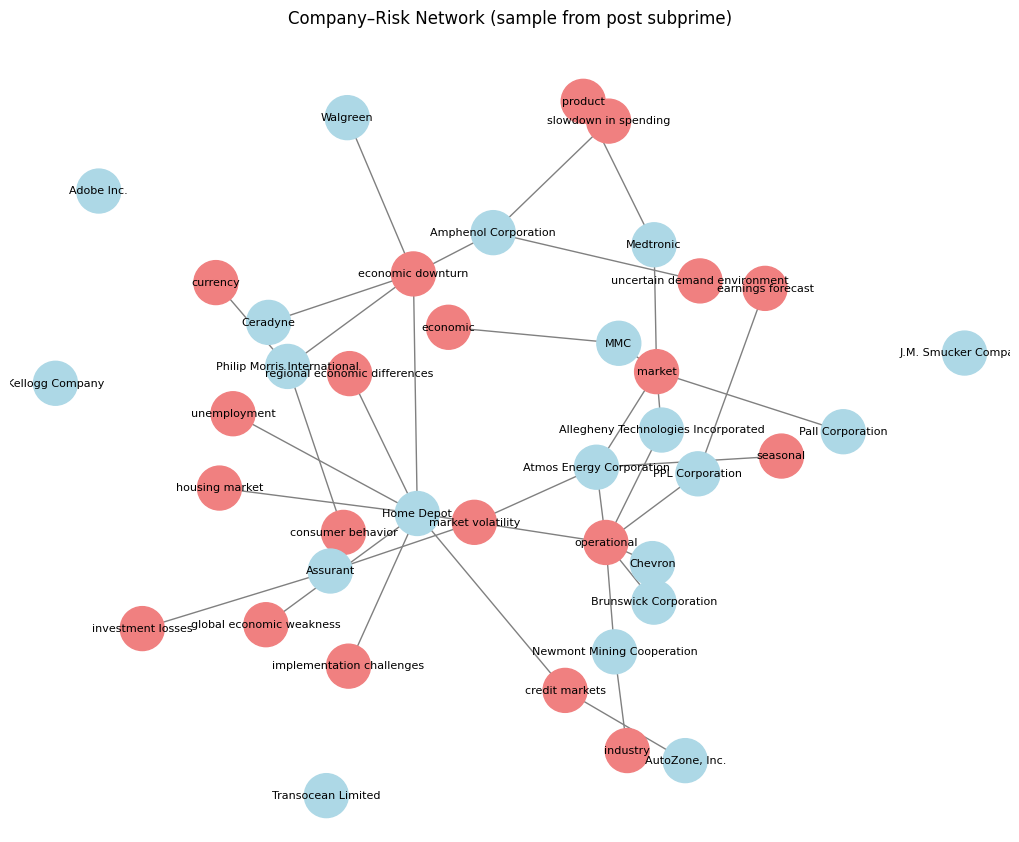

In [26]:
# Focus on top 20 nodes
sub_nodes = list(df_post["company"].unique())[:20] + list(df_post["risk_type"].unique())[:20]
H = G_post.subgraph(sub_nodes)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(H, k=0.5)
node_colors = ["lightblue" if G_post.nodes[n]["type"] == "company" else "lightcoral" for n in H.nodes()]

nx.draw(
    H,
    pos,
    with_labels=True,
    node_color=node_colors,
    edge_color="gray",
    font_size=8,
    node_size=1000,
)
plt.title("Company–Risk Network (sample from post subprime)")
plt.show()


# Combined Graph

In [15]:
def build_graph(df, year):
    G = nx.Graph()
    
    for _, row in df.iterrows():
        company = row["company"]
        risk = row["risk_type"]
        
        # Add typed nodes
        G.add_node(company, type="company")
        G.add_node(risk, type="risk")
        
        # Add edges with year + count
        if G.has_edge(company, risk):
            G[company][risk]["weight"] += 1
        else:
            G.add_edge(company, risk, weight=1, year=year)
    
    return G

G_2006 = build_graph(df_pre, 2006)
G_2008 = build_graph(df_post, 2008)

In [16]:
G_combined = nx.Graph()

def add_graph(G, year):
    for n, attr in G.nodes(data=True):
        G_combined.add_node(n, **attr)
    
    for u, v, data in G.edges(data=True):
        if G_combined.has_edge(u, v):
            # Merge: append year to list, add weight
            G_combined[u][v]["weight"] += data["weight"]
            G_combined[u][v]["years"].add(data["year"])
        else:
            G_combined.add_edge(u, v, weight=data["weight"], years={data["year"]})

# merge both
add_graph(G_2006, 2006)
add_graph(G_2008, 2008)


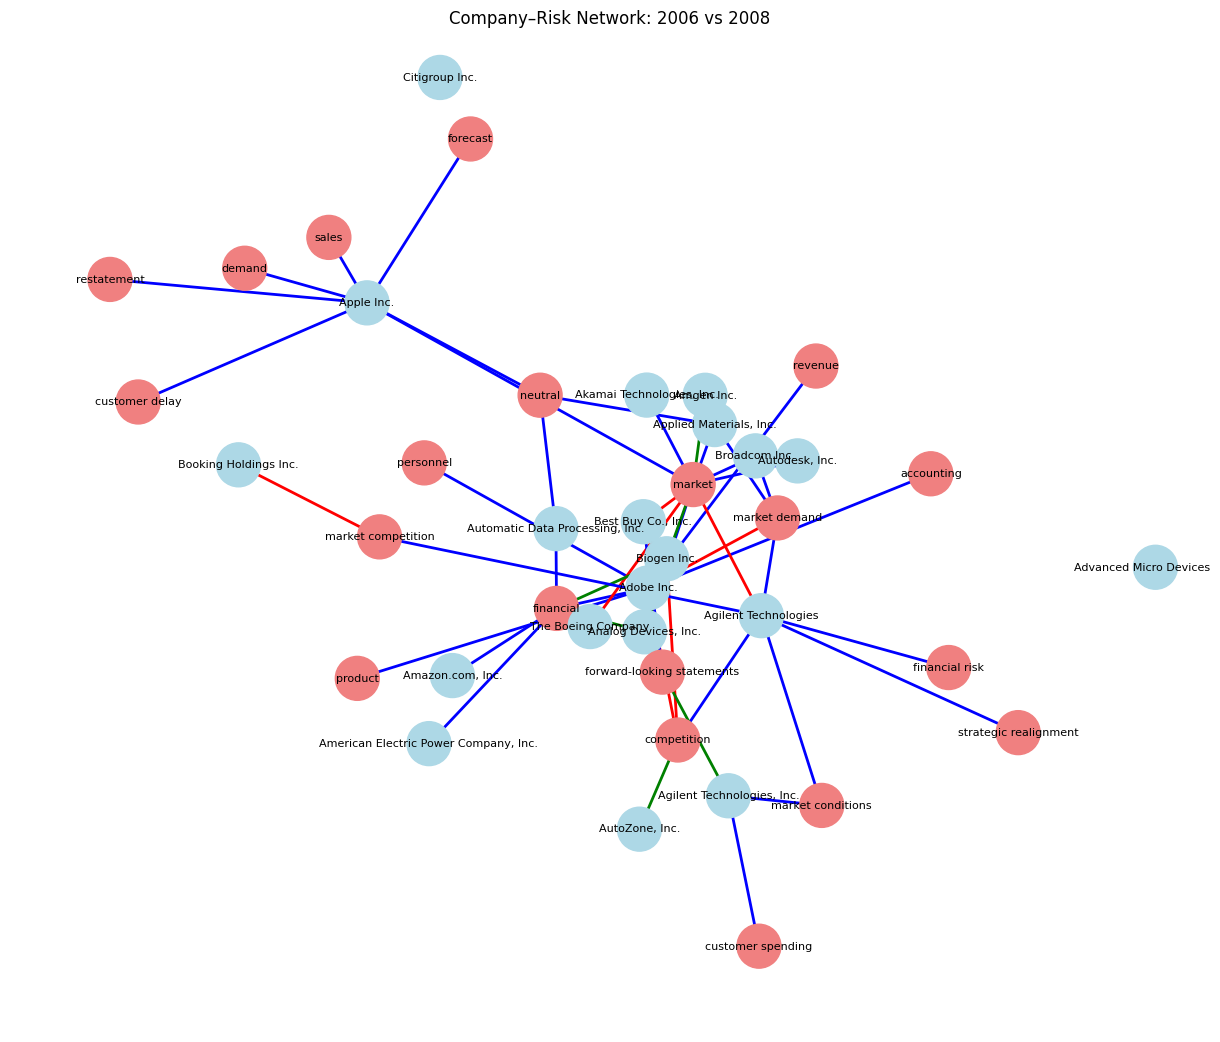

In [17]:
def edge_color(data):
    years = data["years"]
    if years == {2006}:
        return "blue"
    elif years == {2008}:
        return "red"
    else:
        return "green"  # appears in both

# Focus on top nodes like before
sub_nodes = list(df_pre["company"].unique())[:20] + list(df_pre["risk_type"].unique())[:20]
H = G_combined.subgraph(sub_nodes)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(H, k=0.5)

node_colors = ["lightblue" if H.nodes[n]["type"] == "company" else "lightcoral"
               for n in H.nodes()]

edge_colors = [edge_color(data) for _, _, data in H.edges(data=True)]

nx.draw(
    H,
    pos,
    with_labels=True,
    node_color=node_colors,
    edge_color=edge_colors,
    width=2,
    font_size=8,
    node_size=1000,
)
plt.title("Company–Risk Network: 2006 vs 2008")
plt.show()


# Network analysis

In [19]:
# Degree centrality: who/what is most connected in 2006
deg_centrality = nx.degree_centrality(G_pre)
top_nodes = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 most central nodes pre-subprime crisis:")
for name, score in top_nodes:
    print(f"{name:<30} {score:.3f}")


Top 10 most central nodes pre-subprime crisis:
operational                    0.139
financial                      0.115
Google, Inc.                   0.066
market                         0.056
Exelon                         0.047
nan                            0.043
forward-looking statements     0.041
competitive                    0.038
AutoZone, Inc.                 0.038
regulatory                     0.032


In [21]:
# Degree centrality: who/what is most connected 2008
deg_centrality = nx.degree_centrality(G_post)
top_nodes = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 most central nodes post-subprime crisis:")
for name, score in top_nodes:
    print(f"{name:<30} {score:.3f}")


Top 10 most central nodes post-subprime crisis:
operational                    0.117
market                         0.064
economic downturn              0.060
financial                      0.055
economic                       0.040
market volatility              0.031
market conditions              0.031
regulatory                     0.026
economic conditions            0.026
Darden Restaurants             0.026


In [22]:
# Get company and risk nodes
companies = [n for n, d in G_pre.nodes(data=True) if d["type"] == "company"]
risks = [n for n, d in G_pre.nodes(data=True) if d["type"] == "risk"]

# Project to company–company network based on shared risks
company_graph = bipartite.weighted_projected_graph(G_pre, companies)

# Top 10 strongest company–company connections
edges_sorted = sorted(company_graph.edges(data=True), key=lambda x: x[2]["weight"], reverse=True)[:10]
print("\nTop 10 company–company shared risk connections:")
for u, v, w in edges_sorted:
    print(f"{u} ↔ {v} (shared risks: {w['weight']})")


Top 10 company–company shared risk connections:
Adobe Inc. ↔ nan (shared risks: 4)
American Electric Power Company, Inc. ↔ Xcel Energy (shared risks: 4)
American Electric Power Company, Inc. ↔ Exelon (shared risks: 4)
EMC ↔ Xilinx (shared risks: 4)
EMC ↔ nan (shared risks: 4)
EMC ↔ Comcast (shared risks: 4)
nan ↔ Starbucks Coffee Company (shared risks: 4)
nan ↔ Comcast (shared risks: 4)
nan ↔ Cisco Systems (shared risks: 4)
Cisco Systems ↔ McGraw-Hill Companies (shared risks: 4)


In [23]:
# Get company and risk nodes
companies = [n for n, d in G_post.nodes(data=True) if d["type"] == "company"]
risks = [n for n, d in G_post.nodes(data=True) if d["type"] == "risk"]

# Project to company–company network based on shared risks
company_graph = bipartite.weighted_projected_graph(G_post, companies)

# Top 10 strongest company–company connections
edges_sorted = sorted(company_graph.edges(data=True), key=lambda x: x[2]["weight"], reverse=True)[:10]
print("\nTop 10 company–company shared risk connections:")
for u, v, w in edges_sorted:
    print(f"{u} ↔ {v} (shared risks: {w['weight']})")


Top 10 company–company shared risk connections:
nan ↔ Devon Energy (shared risks: 4)
Biogen Inc. ↔ MBIA (shared risks: 4)
Atmos Energy Corporation ↔ Murphy Oil Corporation (shared risks: 3)
Atmos Energy Corporation ↔ MBIA (shared risks: 3)
Atmos Energy Corporation ↔ TSYS (shared risks: 3)
Atmos Energy Corporation ↔ Biogen Inc. (shared risks: 3)
Atmos Energy Corporation ↔ Unum Group (shared risks: 3)
Home Depot ↔ GM (shared risks: 3)
Home Depot ↔ ArvinMeritor (shared risks: 3)
Home Depot ↔ AMETEK, Inc. (shared risks: 3)
